### Importing libraries

In [1]:
import nltk

In [2]:
# nltk.download_shell()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn.model_selection as sms
import sklearn.preprocessing as sp
import sklearn.linear_model as slm
import sklearn.metrics as sm
import sklearn.ensemble as ens
from warnings import filterwarnings 
filterwarnings('ignore') # to ignore warnings
import sklearn.linear_model as slm
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

### Loading dataset

In [4]:
df=pd.read_table("D:\Data\Gamboo\Restaurant  Reviews\Reviews.tsv")
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


### EDA, Preprocesssing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [6]:
df['Liked'].value_counts()

1    500
0    500
Name: Liked, dtype: int64

In [7]:
df['length']=df['Review'].apply(len)
df.head(3)

,Review,Liked,length
0,Wow... Loved this place.,1,24
1,Crust is not good.,0,18
2,Not tasty and the texture was just nasty.,0,41


In [8]:
df.groupby('Liked').describe()

length                                                   
       count   mean        std   min    25%   50%    75%    max
Liked                                                          
0      500.0  60.75  34.224935  11.0  33.00  52.5  84.00  149.0
1      500.0  55.88  30.219464  11.0  32.75  49.5  73.25  148.0

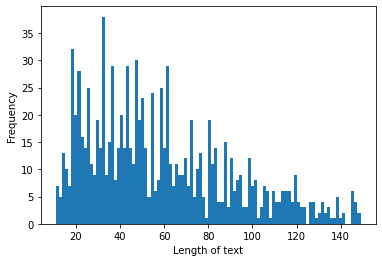

In [9]:
#sns.boxplot(messages['length'])
df['length'].plot.hist(bins=100)
plt.xlabel('Length of text')
plt.show()

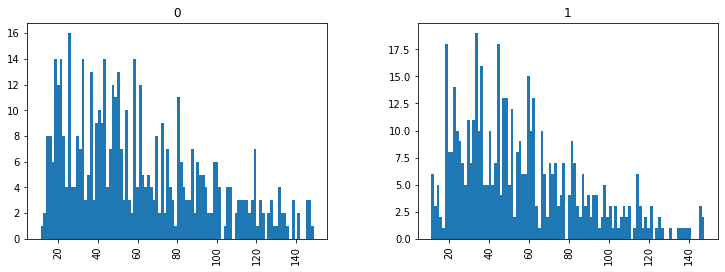

In [10]:
df.hist(column='length',by='Liked', bins=100, figsize=(12,4))
plt.show()

In the **EDA** section, graphs and statistic outcomes display that **"Liked"** and **"Not Liked"** messages generally hold same counted or lengthed words, but **"Not Liked"** messaged hold little bit more rather than **"Liked"**, because, naturally, people use words more while complaining :)

In [11]:
l_msg = df[df['Liked'] == 1]
nl_msg = df[df['Liked']== 0]
# Create numpy list to visualize using wordcloud
l_msg_text = " ".join(l_msg['Review'].to_numpy().tolist())
nl_msg_text = " ".join(nl_msg['Review'].to_numpy().tolist())

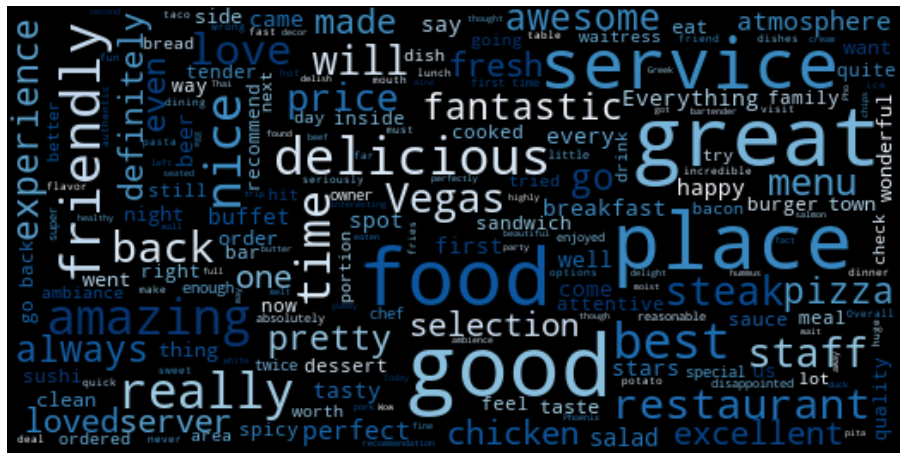

In [12]:
# wordcloud of liked reviews
l_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS, max_font_size=50, background_color ="black",
                          colormap='Blues').generate(l_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(l_msg_cloud, interpolation='bilinear')
plt.axis('off') # not display axis
plt.show()

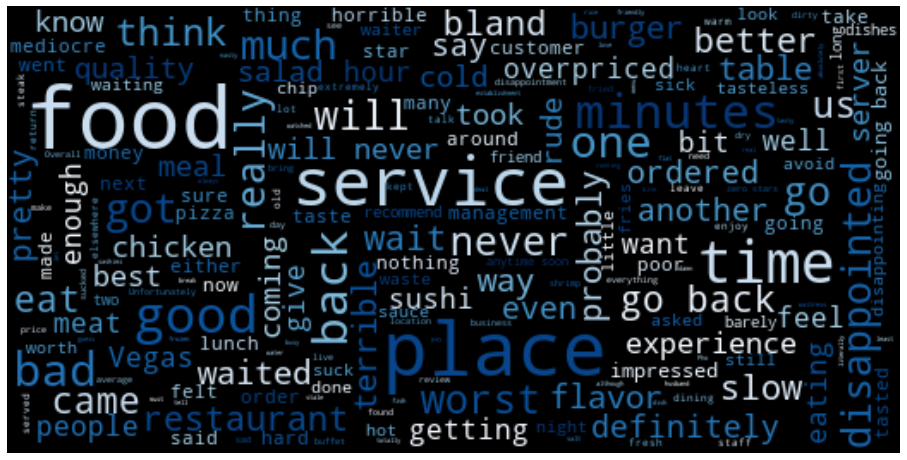

In [13]:
# wordcloud of Not liked reviews
nl_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", 
                           colormap='Blues').generate(nl_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(nl_msg_cloud, interpolation='bilinear')
plt.axis('off') # not to display
plt.show()

In [14]:
def text_process(data):
    # removing punc
    # removing stopwords
    nopunc=[char for char in data if char not in string.punctuation]
    nopunc=''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [15]:
df.iloc[:3,0].apply(text_process)

0        [Wow, Loved, place]
1              [Crust, good]
2    [tasty, texture, nasty]
Name: Review, dtype: object

In [16]:
# tokenization- making tokens
# stemming- considering as unique words which have same root(ran, running, run)
# vectorization- 1.CountVectorization-Spr.Mat

In [17]:
transformer1=CountVectorizer(analyzer=text_process).fit(df['Review'])

In [18]:
len(transformer1.vocabulary_)

2159

In [19]:
transformed=transformer1.transform(df['Review'])

In [20]:
transformed.shape

(1000, 2159)

In [21]:
print('Sparsity:', 1-(100.0 * transformed.nnz/(transformed.shape[0]*transformed.shape[1])))

Sparsity: 0.7403427512737378


**TfidfTransformer** transforms a count matrix to a normalized tf or tf-idf representation. Tf means term-frequency while 
tf-idf means term-frequency times inverse document-frequency

In [22]:
tfidf_transformer = TfidfTransformer().fit(transformed)

In [23]:
review_tfidf=tfidf_transformer.transform(transformed)

In [24]:
review_tfidf.shape

(1000, 2159)

### Splitting data

In [25]:
x_train, x_test, y_train, y_test = sms.train_test_split(review_tfidf, df['Liked'], test_size=0.25, random_state=25)

In [26]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(750, 2159) (250, 2159) (750,) (250,)


## Modelling

In [27]:
# to merge all scores and metrics results altogether
performance=pd.DataFrame(data=None, index=['BAS','AS'])
performance

""
BAS
AS


In [28]:
# creating function to evaluate model at one run
def evaluate(model,model_name):
    performance[model_name]=[sm.balanced_accuracy_score(y_test, model.predict(x_test)),
    sm.accuracy_score(y_test, model.predict(x_test)) ]
    
    print(sm.classification_report(y_test, model.predict(x_test)))
    print("--------Balanced Accuracy Score--------")
    print(sm.balanced_accuracy_score(y_test, model.predict(x_test)))
    print("-------Accuracy Score------------------")
    print(sm.accuracy_score(y_test, model.predict(x_test)))
    
pd.options.display.float_format = '{:.3f}'.format

#### Logistic regression

We will do **Hyperparameter tuning** to find **otimal best** parameters in some models

In [29]:
parameters = {'penalty':('l1','l2','elastic', 'none'),'C':[1, 10, 50, 100] }
lr1 = slm.LogisticRegression()
clf1 = sms.GridSearchCV(lr1, parameters)
clf1.fit(x_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [1, 10, 50, 100],
                         'penalty': ('l1', 'l2', 'elastic', 'none')})

In [30]:
evaluate(clf1, 'Log_reg_0.5')

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       132
           1       0.76      0.74      0.75       118

    accuracy                           0.76       250
   macro avg       0.76      0.76      0.76       250
weighted avg       0.76      0.76      0.76       250

--------Balanced Accuracy Score--------
0.7625834617360041
-------Accuracy Score------------------
0.764


#### SVC classification model

In [31]:
parameters = {'C':[1, 10, 50, 100] }
svc = svm.SVC()
clf2 = sms.GridSearchCV(svc, parameters)
clf2.fit(x_train, y_train)
clf2.best_params_

{'C': 1}

In [32]:
evaluate(clf2, 'SVC')

              precision    recall  f1-score   support

           0       0.76      0.81      0.78       132
           1       0.77      0.71      0.74       118

    accuracy                           0.76       250
   macro avg       0.76      0.76      0.76       250
weighted avg       0.76      0.76      0.76       250

--------Balanced Accuracy Score--------
0.7612352336928607
-------Accuracy Score------------------
0.764


#### Naive Bayes Classification

In [33]:
bc = MultinomialNB()
bc.fit(x_train, y_train)

MultinomialNB()

In [34]:
evaluate(bc, 'NaiveBayes')

              precision    recall  f1-score   support

           0       0.83      0.67      0.74       132
           1       0.70      0.85      0.77       118

    accuracy                           0.76       250
   macro avg       0.77      0.76      0.76       250
weighted avg       0.77      0.76      0.75       250

--------Balanced Accuracy Score--------
0.7608500256805342
-------Accuracy Score------------------
0.756


### Ensemble methods

#### RandomForest classification model

In [35]:
parameters = { 'n_estimators':[i for i in range(150,200,10)] }
rfc = ens.RandomForestClassifier(random_state=25)
clf3 = sms.GridSearchCV(rfc, parameters)
clf3.fit(x_train, y_train)

clf3.best_params_

{'n_estimators': 150}

In [36]:
evaluate(clf3, 'R_Forest')

              precision    recall  f1-score   support

           0       0.73      0.89      0.80       132
           1       0.84      0.63      0.72       118

    accuracy                           0.77       250
   macro avg       0.78      0.76      0.76       250
weighted avg       0.78      0.77      0.76       250

--------Balanced Accuracy Score--------
0.7605290190035953
-------Accuracy Score------------------
0.768


#### ExtraTree classification model

In [37]:
parameters = { 'n_estimators':[i for i in range(80,200,10)] }
etc = ens.ExtraTreesClassifier(random_state=25)
clf4 = sms.GridSearchCV(etc, parameters)
clf4.fit(x_train, y_train)

clf4.best_params_

{'n_estimators': 110}

In [38]:
evaluate(clf4, 'ExTree')

              precision    recall  f1-score   support

           0       0.75      0.86      0.80       132
           1       0.82      0.68      0.74       118

    accuracy                           0.78       250
   macro avg       0.78      0.77      0.77       250
weighted avg       0.78      0.78      0.77       250

--------Balanced Accuracy Score--------
0.7708012326656395
-------Accuracy Score------------------
0.776


#### GradientBoosting classification model

In [39]:
parameters = { 'learning_rate':[0.1,0.01,0.001], 'n_estimators':[50,100,150,200,250] }
gbc = ens.GradientBoostingClassifier(random_state=25)
clf5 = sms.GridSearchCV(gbc, parameters)
clf5.fit(x_train, y_train)

clf5.best_params_

{'learning_rate': 0.1, 'n_estimators': 100}

In [40]:
evaluate(clf5, 'GradientBC')

              precision    recall  f1-score   support

           0       0.72      0.89      0.80       132
           1       0.84      0.62      0.71       118

    accuracy                           0.76       250
   macro avg       0.78      0.76      0.76       250
weighted avg       0.78      0.76      0.76       250

--------Balanced Accuracy Score--------
0.756291730868002
-------Accuracy Score------------------
0.764


#### AdaBoost classification model

In [41]:
parameters = { 'learning_rate':[0.1, 1, 2], 'n_estimators':[50,100,150,200]}
abc = ens.AdaBoostClassifier(random_state=25)
clf6 = sms.GridSearchCV(abc, parameters)
clf6.fit(x_train, y_train)

clf6.best_params_

{'learning_rate': 0.1, 'n_estimators': 200}

In [42]:
evaluate(clf6, 'AdaBC')

              precision    recall  f1-score   support

           0       0.70      0.88      0.78       132
           1       0.81      0.58      0.68       118

    accuracy                           0.74       250
   macro avg       0.76      0.73      0.73       250
weighted avg       0.75      0.74      0.73       250

--------Balanced Accuracy Score--------
0.7317668207498715
-------Accuracy Score------------------
0.74


### K Nearest Neigbour Classfier

In [43]:
n = list(range(2, 15))
bac = []
for k in n:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    bac.append(sm.balanced_accuracy_score(y_test, knn.predict(x_test)))

Let us define **"n_neighbors"** value to get high preformance in KNN

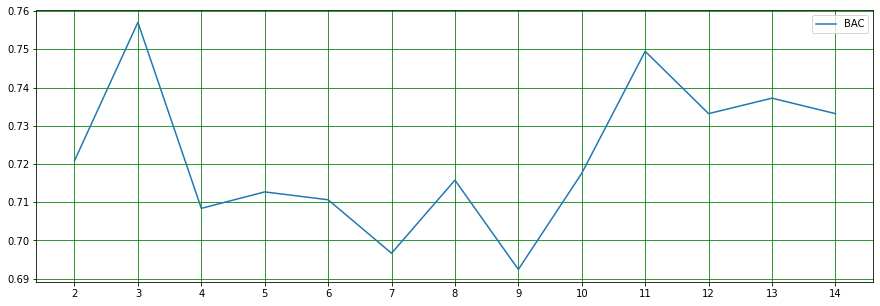

In [44]:
fig = plt.figure(figsize=(15,5))
ax = fig.gca()
ax.plot(n, bac)

ax.legend(['BAC'])

ax.set_xticks(n)
#ax.set_yticks(np.arange(0, 0.7, 0.05))

ax.grid(color='green')
plt.show()

In [45]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [46]:
evaluate(knn, 'KNN')

              precision    recall  f1-score   support

           0       0.83      0.67      0.74       132
           1       0.69      0.85      0.76       118

    accuracy                           0.75       250
   macro avg       0.76      0.76      0.75       250
weighted avg       0.77      0.75      0.75       250

--------Balanced Accuracy Score--------
0.7570621468926553
-------Accuracy Score------------------
0.752


#### Voting regression model

In [47]:
performance

,Log_reg_0.5,SVC,NaiveBayes,R_Forest,ExTree,GradientBC,AdaBC,KNN
BAS,0.763,0.761,0.761,0.761,0.771,0.756,0.732,0.757
AS,0.764,0.764,0.756,0.768,0.776,0.764,0.740,0.752


In [48]:
# estimators are prefitted models those were evaluated
vc = ens.VotingClassifier([('ExTree', clf4), ('Log_reg_0.5', lr1), ('RandomF', clf3)])
vc.fit(x_train, y_train)
evaluate(vc, 'VotingC')

              precision    recall  f1-score   support

           0       0.76      0.86      0.81       132
           1       0.82      0.69      0.75       118

    accuracy                           0.78       250
   macro avg       0.79      0.78      0.78       250
weighted avg       0.79      0.78      0.78       250

--------Balanced Accuracy Score--------
0.7792758089368259
-------Accuracy Score------------------
0.784


In [49]:
performance

,Log_reg_0.5,SVC,NaiveBayes,R_Forest,ExTree,GradientBC,AdaBC,KNN,VotingC
BAS,0.763,0.761,0.761,0.761,0.771,0.756,0.732,0.757,0.779
AS,0.764,0.764,0.756,0.768,0.776,0.764,0.740,0.752,0.784


I merged evaluation metrics and scores of all models we trained into **"performance"** in order to make the comparison. So, that can be seen some models performed better like **RandomForest, ExtraTree, Logistic, Voting Classification** models. Particularly, doing of **hyperparameter tuning** boosted performance on closer optimal values

According to the comparison of models performances, the **Voting Classification** is the optimal model with **0.78 %** to pick and to utilize as the major

### Lorenz curve

In [50]:
fpr, tpr, threshold=sm.roc_curve(y_test, pd.DataFrame(clf5.predict_proba(x_test))[1])

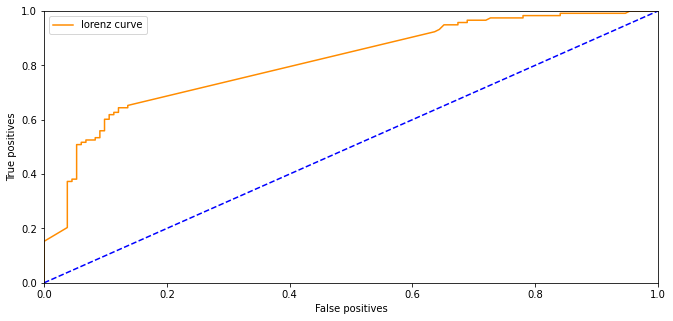

In [51]:
plt.figure(figsize=(11,5))
plt.plot(fpr, tpr, 'darkorange')
plt.plot([0,1],[0,1], 'b--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False positives')
plt.ylabel('True positives')
plt.legend(['lorenz curve'])
plt.show()

In [52]:
sm.auc(fpr, tpr)

0.8105739599383668

More area under the **Lorenz curve** as well as higher **Gini Index(Coefficient)** indicates better performance at prediction

#### (auc-0.5)/0.5=2*auc(fpr,tpr)-1

In [53]:
# gini index(coefficient)
gini=2*sm.auc(fpr, tpr)-1
gini

0.6211479198767336

## Evaluating model manually

In [57]:
def estimate_my_feeling(my_review):   
    review_mine =transformer1.transform(my_review)
    review_mine=tfidf_transformer.transform(review_mine)
    if vc.predict(review_mine) == 1:
        print("Positive, I liked")
    else:
        print("Negative, I don't liked")

In [58]:
review1 = ['It was awful, I will not come here again']
review2 = ['Delicious, everyone should come to test it']

estimate_my_feeling(review1)
estimate_my_feeling(review2)

Negative, I don't liked
Positive, I liked


At end of the my work, I created **estimate_my_feeling** function to predict our text, review according to decided major model

**Thanks!**